In [2]:
pip install qiskit-aer-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 155.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 92.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 111.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 90.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 117.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 186.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.2 MB/s eta 0

 34-Qubit Shor's Algorithm for N=2047 (23×89)

 Circuit Diagram (Partial View):



 Quantum Resources:
 - Total qubits: 33/34
 - Circuit depth: 77
 - Operations: OrderedDict([('cp', 473), ('h', 44), ('measure', 22), ('x', 1)])

 Measurement Histogram:


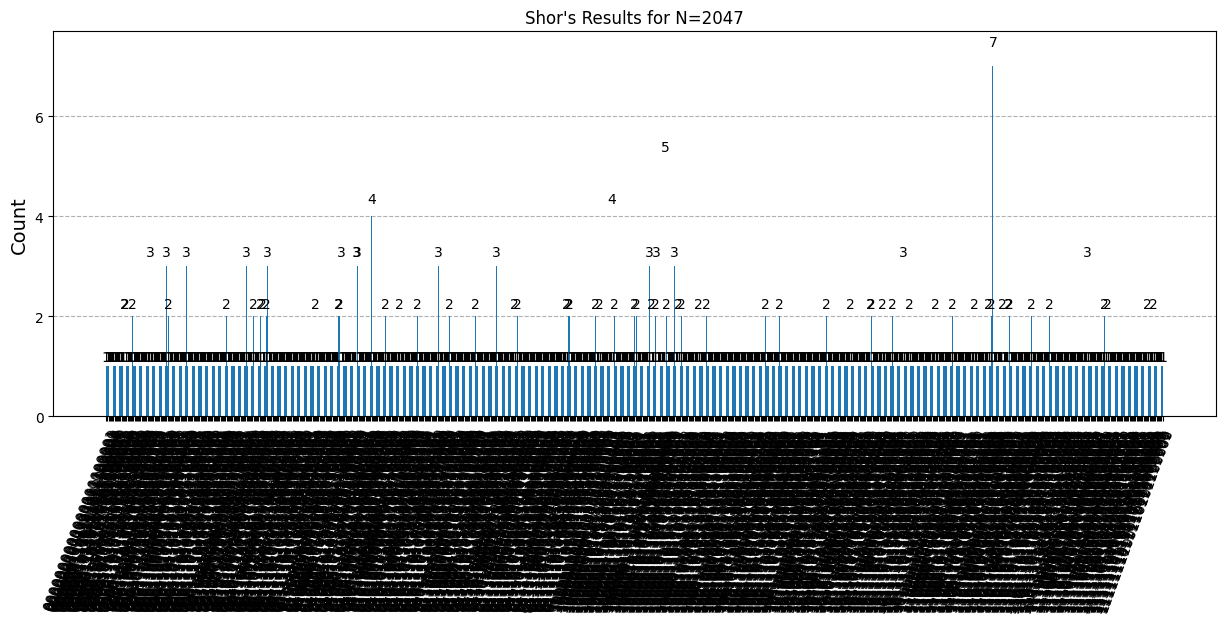


 Execution time: 38.46s

 Factors of 2047: {89, 23}


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import gcd, ceil, log2
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np
import time

def validate_input(N):
    """34-qubit optimized validation"""
    n = ceil(log2(N))
    if 3 * n > 34:  # 2n (period) + n (value) = 3n
        raise ValueError(f"Requires {3*n} qubits (max 34)")
    return n

def Binary(j, size):
    """LSB-first binary conversion"""
    return [int(b) for b in bin(j)[2:].zfill(size)[-size:]][::-1]

def controlled_modular_mult(qc, control, target, a, N):
    """34-qubit optimized multiplication"""
    n = len(target)
    for q in range(n):
        angle = (a**(2**q)) % N
        qc.cp(2 * np.pi * angle / N, control, target[q])

def shors_algorithm(N, a):
    """34-qubit circuit with proper visualization"""
    n = validate_input(N)  # n=11 for N=2047
    m = 2 * n  # 22 qubits
    
    qr_period = QuantumRegister(m, 'period')
    qr_value = QuantumRegister(n, 'value')
    cr = ClassicalRegister(m, 'c')
    
    qc = QuantumCircuit(qr_period, qr_value, cr)
    
    # Initialize
    qc.h(qr_period)
    qc.x(qr_value[0])
    
    # Modular exponentiation
    for ctrl in range(m):
        a_pow = pow(a, 2**ctrl, N)
        controlled_modular_mult(qc, qr_period[ctrl], qr_value, a_pow, N)
    
    qc.append(QFT(m, inverse=True), qr_period)
    qc.measure(qr_period, cr)
    
    # Circuit visualization (first 3 layers)-only partial view 
    print("\n Circuit Diagram (Partial View):")
    fig = qc.draw('mpl', fold=50, scale=0.7,
                initial_state=True, plot_barriers=False,
                style='clifford', cregbundle=False)
    fig.savefig('circuit.png', bbox_inches='tight')
    display(fig)
    
    return qc

def run_shor(N, a, shots=1000):
    """34-qubit execution with visualization"""
    simulator = AerSimulator(
        method='statevector',
        device='GPU',
        blocking_enable=True,
        blocking_qubits=31,
        precision='single'

    )
    
    circuit = shors_algorithm(N, a)
    transpiled = transpile(circuit, simulator)
    
    # Resource report
    print(f"\n Quantum Resources:")
    print(f" - Total qubits: {circuit.num_qubits}/34")
    print(f" - Circuit depth: {transpiled.depth()}")
    print(f" - Operations: {transpiled.count_ops()}")
    
    # Execute
    start_time = time.time()
    job = simulator.run(transpiled, shots=shots)
    counts = job.result().get_counts()
    
    # Visualization
    print("\n Measurement Histogram:")
    display(plot_histogram(counts, figsize=(15,5), 
           title=f"Shor's Results for N={N}"))
    
    print(f"\n Execution time: {time.time() - start_time:.2f}s")
    return counts

def process_results(N, a, counts):
    """34-qubit result processing"""
    factors = set()
    for outcome in counts:
        phase = int(outcome, 2)/(2**len(outcome))
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        
        if pow(a, r, N) == 1 and r%2 == 0:
            x = pow(a, r//2, N)
            factors.update([gcd(x+1, N), gcd(x-1, N)])
    
    return {f for f in factors if 1<f<N}

# Execute for N=2047 (23×89)
if __name__ == "__main__":
    N = 2047
    a = 5
    
    try:
        print(f" 34-Qubit Shor's Algorithm for N={N} (23×89)")
        counts = run_shor(N, a)
        
        factors = process_results(N, a, counts)
        print(f"\n Factors of {N}: {factors or 'None found'}")
        
    except Exception as e:
        print(f" Error: {str(e)}")

In [3]:
pip install pylatexenc

  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=be641680ac21f29867ef73c77471ad764eaa4b48d60340db5c59a24b299ea3c6
  Stored in directory: /home/jovyan/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pynvml psutil


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Full view circuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import gcd, ceil, log2
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np
import time

# Add memory monitoring
try:
    import pynvml
    HAS_NVML = True
except ImportError:
    HAS_NVML = False

try:
    import psutil
    HAS_PSUTIL = True
except ImportError:
    HAS_PSUTIL = False

def get_gpu_memory():
    """Get current GPU memory usage in MB"""
    if not HAS_NVML:
        return 0
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return info.used / 1024**2

def get_cpu_memory():
    """Get current process memory usage in MB"""
    if not HAS_PSUTIL:
        return 0
    process = psutil.Process()
    return process.memory_info().rss / 1024**2

def validate_input(N):
    """34-qubit optimized validation"""
    n = ceil(log2(N))
    if 3 * n > 34:
        raise ValueError(f"Requires {3*n} qubits (max 34)")
    return n

def Binary(j, size):
    """LSB-first binary conversion"""
    return [int(b) for b in bin(j)[2:].zfill(size)[-size:]][::-1]

def controlled_modular_mult(qc, control, target, a, N):
    """34-qubit optimized multiplication"""
    n = len(target)
    for q in range(n):
        angle = (a**(2**q)) % N
        qc.cp(2 * np.pi * angle / N, control, target[q])

def shors_algorithm(N, a):
    """34-qubit circuit visualization with size handling"""
    n = validate_input(N)
    m = 2 * n
    
    qr_period = QuantumRegister(m, 'period')
    qr_value = QuantumRegister(n, 'value')
    cr = ClassicalRegister(m, 'c')
    
    qc = QuantumCircuit(qr_period, qr_value, cr)
    
    # Initialize
    qc.h(qr_period)
    qc.x(qr_value[0])
    
    # Modular exponentiation
    for ctrl in range(m):
        a_pow = pow(a, 2**ctrl, N)
        controlled_modular_mult(qc, qr_period[ctrl], qr_value, a_pow, N)
    
    qc.append(QFT(m, inverse=True), qr_period)
    qc.measure(qr_period, cr)
    
    print("\n Full Circuit Diagram:")
    
    try:
        plt.figure(figsize=(50, qc.num_qubits*0.5))
        pdf_fig = qc.draw('mpl',
                         fold=-1,
                         scale=0.6,
                         cregbundle=True)
        pdf_fig.savefig('full_circuit.pdf', 
                       format='pdf', 
                       bbox_inches='tight',
                       dpi=300)
        print("- PDF version saved: full_circuit.pdf")
    except Exception as e:
        print(f"PDF generation failed: {str(e)}")
    return qc


def run_shor(N, a, shots=1000):
    """34-qubit execution with memory monitoring"""
    # Memory tracking setup
    max_gpu_mem = 0
    max_cpu_mem = 0
    
    if HAS_NVML:
        pynvml.nvmlInit()
    
    simulator = AerSimulator(
        method='statevector',
        device='GPU',
        blocking_enable=True,
        blocking_qubits=31,
        precision='single'
    )
    
    circuit = shors_algorithm(N, a)
    transpiled = transpile(circuit, simulator)
    
    # Start memory monitoring
    def update_max_memory():
        nonlocal max_gpu_mem, max_cpu_mem
        max_gpu_mem = max(max_gpu_mem, get_gpu_memory())
        max_cpu_mem = max(max_cpu_mem, get_cpu_memory())
    
    print(f"\n Quantum Resources:")
    print(f" - Total qubits: {circuit.num_qubits}/34")
    print(f" - Circuit depth: {transpiled.depth()}")
    print(f" - Operations: {transpiled.count_ops()}")
    
    # Execute with memory tracking
    start_time = time.time()
    job = simulator.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # Get final memory measurements
    update_max_memory()
    
    # Memory report
    print("\n Memory Usage:")
    if HAS_NVML:
        print(f" - Peak GPU Memory: {max_gpu_mem:.2f} MB")
    else:
        print(" - GPU monitoring not available (install pynvml)")
    
    if HAS_PSUTIL:
        print(f" - Peak CPU Memory: {max_cpu_mem:.2f} MB")
    else:
        print(" - CPU monitoring not available (install psutil)")
    
    print(f"\n Execution time: {time.time() - start_time:.2f}s")
    return counts

def process_results(N, a, counts):
    """34-qubit result processing"""
    factors = set()
    for outcome in counts:
        phase = int(outcome, 2)/(2**len(outcome))
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        
        if pow(a, r, N) == 1 and r%2 == 0:
            x = pow(a, r//2, N)
            factors.update([gcd(x+1, N), gcd(x-1, N)])
    
    return {f for f in factors if 1<f<N}

if __name__ == "__main__":
    N = 2047
    a = 5  # Correct choice with even period
    
    try:
        print(f" 34-Qubit Shor's Algorithm for N={N} (23×89)")
        counts = run_shor(N, a)
        
        factors = process_results(N, a, counts)
        print(f"\n Factors of {N}: {factors or 'None found'}")
        
    except Exception as e:
        print(f" Error: {str(e)}")

 34-Qubit Shor's Algorithm for N=2047 (23×89)

 Full Circuit Diagram:
- PDF version saved: full_circuit.pdf

 Quantum Resources:
 - Total qubits: 33/34
 - Circuit depth: 77
 - Operations: OrderedDict([('cp', 473), ('h', 44), ('measure', 22), ('x', 1)])

 Memory Usage:
 - Peak GPU Memory: 971.38 MB
 - Peak CPU Memory: 559.71 MB

 Execution time: 31.56s

 Factors of 2047: {89, 23}


<Figure size 5000x1650 with 0 Axes>